In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import regex
import re
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from textblob import Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_curve,auc
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.metrics import classification_report
plt.style.use('ggplot')
%matplotlib notebook

## Chargement des données et néttoyage:

In [2]:
def fonction_nettoyage_text(df):
    # supprission des ponctuations
    rm_ponct = str.maketrans('','',string.punctuation)
    df = df.apply(lambda x:x.translate(rm_ponct))
    # suppression les unicodes
    df = df.apply(lambda x:x.encode("ascii","ignore").decode("utf-8"))
                                                
    # suppression des URLs
    df = df.apply(lambda x:re.sub(r'http\S+',"",x))
    
    # suppression des stopwords
    stop_en = stopwords.words("english")
    df = df.apply(lambda x:" ".join(x.lower() for x in np.str(x).split() if x.lower() not in stop_en))
                                                  # Lemmatisation
    df = df.apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
                  
    return(df)

## Split train-test validation:

In [3]:
dataset = pd.read_csv("data_set_version_final.csv")
dataset.resume=fonction_nettoyage_text(dataset.resume)

In [4]:
X_train,X_test,Y_train,y_test = train_test_split(dataset.resume,dataset.Labels,test_size=0.3,shuffle=True)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.3,shuffle=True)

## CBOW:
Dans ce notebook, on va faire la même chose que l'on a réalisé dans le notebook SkpiGram_Offre-Emploi pour tester si l'on va avoir des meilleurs résultats ou non si l'on utilise le CBOW.

In [7]:
from Word2VecTransformer import Embedding_Word2Vec

Nous allon changer la valeur de $n_sg=0$ pour appliquer CBOW au lieu de Skip-Gram.

In [8]:
word2vecmodel=Embedding_Word2Vec(n_size=150,n_window=10,n_min_count=5,n_workers=4,n_sg=0)

In [9]:
word2vecmodel.fit(x_train)

In [10]:
X_embeded_train_w2v=word2vecmodel.transform(x_train)
X_embeded_val_w2v=word2vecmodel.transform(x_val)
X_embeded_test_w2v=word2vecmodel.transform(X_test)

/home/tantely/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Utilisons maintenant les différentes algorithmes de classifications sur ces plongements de mots que l'on a réalisé.

## SVM:

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 C optimal = 43.93970560760795


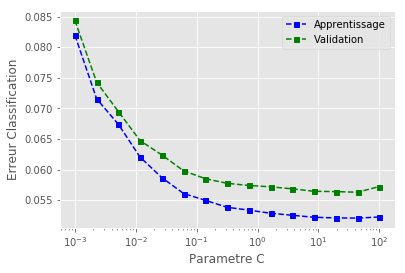

In [11]:
vectC = np.logspace(-3, 2, 15)
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
clf_svm=LinearSVC(C=1)

for ind_C, C in enumerate(vectC):
    clf_svm.C = C
    clf_svm.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, clf_svm.predict(X_embeded_val_w2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, clf_svm.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre C")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

## Qualité du modèle:

In [12]:
from sklearn.metrics import recall_score,average_precision_score,f1_score
from sklearn.calibration import CalibratedClassifierCV

In [13]:
clf_svm.C = Copt
clf_svm_prob=CalibratedClassifierCV(clf_svm,cv=5)
clf_svm_prob.fit(X_embeded_train_w2v, y_train)
prediction_proba=clf_svm_prob.predict_proba(X_embeded_test_w2v)

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

In [14]:
prediction=clf_svm.predict(X_embeded_test_w2v)
print(classification_report(y_test, prediction))

                   precision    recall  f1-score   support

Finance_actuariat       0.98      0.99      0.99      1569
       chirurgien       0.94      0.92      0.93      7910
     cryptography       0.97      0.96      0.96      3166
   data scientist       0.92      0.94      0.93      3416
          dentist       0.95      0.94      0.94      8188
        developer       0.95      0.90      0.93      2270
ditital_marketing       0.99      0.99      0.99      3545
 network_engineer       0.98      0.98      0.98      3684
            nurse       0.92      0.94      0.93     10900
       pharmacist       0.94      0.94      0.94      6385
          robotic       0.95      0.96      0.96      5734

        micro avg       0.94      0.94      0.94     56767
        macro avg       0.95      0.95      0.95     56767
     weighted avg       0.94      0.94      0.94     56767



In [24]:
print("recall:{}".format(recall_score(y_test, prediction,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,prediction)))
print("F1-score:{}".format(f1_score(y_test,prediction,average='weighted')))

recall:0.9447214050416616
accuracy:0.9447214050416616
F1-score:0.9447287929022321


## Logisitic Regression:

In [15]:
rl=LogisticRegression(multi_class="auto",solver="lbfgs")

4it [00:12,  3.13s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
5it [00:18,  4.12s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
6it [00:25,  4.80s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
7it [00:31,  5.26s/it]/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
8it [00:37,  5.59s/it]/home/tantely/anaconda3/lib/python3.6/site-pac


 C optimal = 5.5


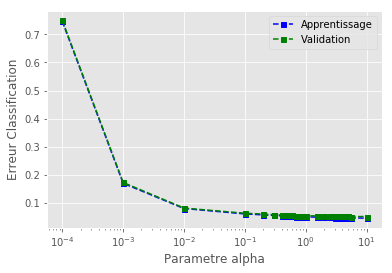

In [16]:
vectC = np.array([1e-4,1e-3,1e-2,1e-1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.5,1.6,2,2.5,3,3.5,4,4.5,5,5.5,10])
err_val = np.empty(vectC.shape[0])
err_app = np.empty(vectC.shape[0])
for ind_C, C in tqdm(enumerate(vectC)):
    rl.C=C
    temp=rl.fit(X_embeded_train_w2v, y_train)
    # calcule erreur sur les donnees de validation et app
    err_val[ind_C] = 1 - accuracy_score(y_val, rl.predict(X_embeded_val_w2v))
    err_app[ind_C] = 1 - accuracy_score(y_train, rl.predict(X_embeded_train_w2v))
err_min_val, ind_min = err_val.min(), err_val.argmin()
Copt = vectC[ind_min]
print("\n C optimal = {}".format(Copt))
# Trace courbe erreur
plt.figure()
plt.semilogx(vectC, err_app, color="blue", linestyle="--", marker="s", markersize=5, label="Apprentissage")
plt.semilogx(vectC, err_val, color="green", linestyle="--", marker="s", markersize=5, label="Validation")
plt.xlabel("Parametre alpha")
plt.ylabel("Erreur Classification")
plt.legend(loc="best")
plt.show()

In [17]:
rl.C=Copt
temp=rl.fit(X_embeded_train_w2v, y_train)
predRL=rl.predict(X_embeded_test_w2v)   
print("recall:{}".format(recall_score(y_test, predRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predRL)))
print("F1-score:{}".format(f1_score(y_test,predRL,average='weighted')))

/home/tantely/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


recall:0.9489315975831029
accuracy:0.9489315975831029
F1-score:0.9489379126786675


In [18]:
print(classification_report(y_test, predRL))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.99      0.99      1569
       chirurgien       0.94      0.92      0.93      7910
     cryptography       0.97      0.96      0.97      3166
   data scientist       0.94      0.93      0.94      3416
          dentist       0.95      0.95      0.95      8188
        developer       0.95      0.92      0.94      2270
ditital_marketing       0.99      0.99      0.99      3545
 network_engineer       0.99      0.98      0.98      3684
            nurse       0.92      0.94      0.93     10900
       pharmacist       0.95      0.94      0.94      6385
          robotic       0.95      0.98      0.96      5734

        micro avg       0.95      0.95      0.95     56767
        macro avg       0.96      0.95      0.96     56767
     weighted avg       0.95      0.95      0.95     56767



In [25]:
print("recall:{}".format(recall_score(y_test, predRL,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,predRL)))
print("F1-score:{}".format(f1_score(y_test,predRL,average='weighted')))

recall:0.9489315975831029
accuracy:0.9489315975831029
F1-score:0.9489379126786675


## KNN:

In [19]:
knn=KNeighborsClassifier()

100%|██████████| 8/8 [4:13:49<00:00, 2183.98s/it]  

With all being CV, best k is 2 and best perf is 0.9767974431889674


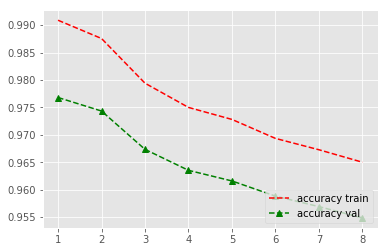

In [20]:
k_values = [2,3,5,6,7,8,9,10]
perf_train=[]
perf_val=[]
for k in tqdm(k_values):
    knn.n_neighbors=k
    knn.fit(X_embeded_train_w2v, y_train)
    y_pred_train = knn.predict(X_embeded_train_w2v)
    y_pred_val=knn.predict(X_embeded_val_w2v)
    scores_train = accuracy_score(y_train, y_pred_train)
    scores_val=accuracy_score(y_val,y_pred_val)
    perf_train.append(scores_train)
    perf_val.append(scores_val)
plt.figure()
plt.plot(range(1,len(perf_train)+1),perf_train,"--r",range(1,len(perf_val)+1),perf_val,"--g^")
plt.legend(['accuracy train', 'accuracy val'],loc="lower right")
print('With all being CV, best k is '    +repr(k_values[perf_val.index(max(perf_val))])+ ' and best perf is ' + repr(max(perf_val)))

In [21]:
knn.n_neighbors=k_values[perf_val.index(max(perf_val))]
knn.fit(X_embeded_train_w2v, y_train)
pred_knn = knn.predict(X_embeded_test_w2v)

In [22]:
print(classification_report(y_test, pred_knn))

                   precision    recall  f1-score   support

Finance_actuariat       0.99      0.99      0.99      1569
       chirurgien       0.95      0.98      0.97      7910
     cryptography       0.99      1.00      0.99      3166
   data scientist       0.96      0.99      0.98      3416
          dentist       0.98      0.98      0.98      8188
        developer       0.99      0.95      0.97      2270
ditital_marketing       0.98      1.00      0.99      3545
 network_engineer       0.99      1.00      0.99      3684
            nurse       0.97      0.96      0.97     10900
       pharmacist       0.99      0.97      0.98      6385
          robotic       0.99      0.98      0.99      5734

        micro avg       0.98      0.98      0.98     56767
        macro avg       0.98      0.98      0.98     56767
     weighted avg       0.98      0.98      0.98     56767



In [23]:
print("recall:{}".format(recall_score(y_test, pred_knn,average='weighted')))
print("accuracy:{}".format(accuracy_score(y_test,pred_knn)))
print("F1-score:{}".format(f1_score(y_test,pred_knn,average='weighted')))

recall:0.9767822854827629
accuracy:0.9767822854827629
F1-score:0.9767731174286239
